## Trigram model with Neural Nets


In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

%matplotlib inline

In [2]:
words = open("../makemore/names.txt", "r").read().splitlines()
len(words), words[0:3]

(32033, ['emma', 'olivia', 'ava'])

In [3]:
chars = sorted(list(set("".join(words))))

stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {s: i for i, s in stoi.items()}

In [4]:
# create the training set of trigrams (ab, y)
xs, ys = [], []

for w in words:
    chs = [".", "."] + list(w) + ["."]
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        # ix1 = stoi[f"{ch1}{ch2}"]
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        # print(f"{ch1}{ch2}  -> {ch3}")
        xs.append((ix1 * 27) + ix2)
        ys.append(ix3)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f"{xs.shape=}, {len(xs)=}, {xs.nelement()=} {xs[0:5]}")
print(f"{ys.shape=}, {len(ys)=}, {ys.nelement()=} {ys[0:5]}")
print(f"Number of examples={len(xs)=}")

xs.shape=torch.Size([228146]), len(xs)=228146, xs.nelement()=228146 tensor([  0,   5, 148, 364, 352])
ys.shape=torch.Size([228146]), len(ys)=228146, ys.nelement()=228146 tensor([ 5, 13, 13,  1,  0])
Number of examples=len(xs)=228146


In [5]:
g = torch.Generator().manual_seed(2147483647)
# TODO: Unsure what the shape of W should be.
W3 = torch.randn((27 * 27, 27), generator=g, requires_grad=True)
W3.shape

torch.Size([729, 27])

In [6]:
losses = []
durations = []

In [7]:
# Gradient descent

for i in range(1000):
    start = datetime.now()

    # Forward pass
    xenc = F.one_hot(xs, num_classes=27**2).float()  # One hot encoded inputs.
    logits = xenc @ W3  # log(counts)
    counts = logits.exp()  # counts, [0, +Inf]
    probs = counts / counts.sum(1, keepdim=True)  # Normalised probability with softmax.

    # For each input pair in xs, pluck label from ys to compute Negative Log Likelihood
    # NOTE: This array indexing here is impressively terse across 2 dimensions.
    loss = -probs[torch.arange(len(xs)), ys].log().mean()

    # Regularization loss
    # reg = 0.01 * W3.pow(2).mean()

    losses.append(loss.item())

    if i % 100 == 0:
        print(f"{i=} loss={loss.item()}")

    # Backward pass
    W3.grad = None
    loss.backward()

    # Update weights
    W3.data += -50 * W3.grad

    durations.append(datetime.now() - start)

i=0 loss=3.792776346206665
i=100 loss=2.5085482597351074
i=200 loss=2.3814938068389893
i=300 loss=2.3280222415924072
i=400 loss=2.297999382019043
i=500 loss=2.278773069381714
i=600 loss=2.26540470123291
i=700 loss=2.2555549144744873
i=800 loss=2.247979164123535
i=900 loss=2.2419605255126953


start=3.7928, end=2.2371


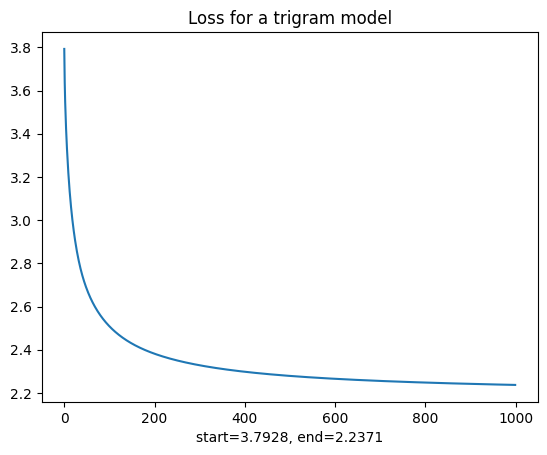

In [8]:
plt.plot(losses)
plt.title("Loss for a trigram model")
plt.xlabel(f"start={losses[0]:.4f}, end={losses[-1]:.4f}")

# The expected loss at the end of training should be close to the mean loss calculated earlier
print(f"start={losses[0]:.4f}, end={losses[-1]:.4f}")

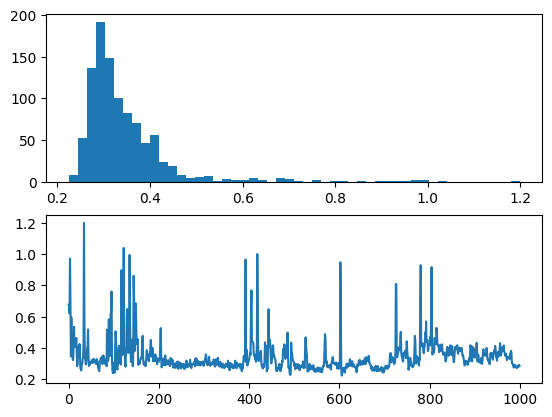

In [9]:
# "Training step durations"
fig, (top, bottom) = plt.subplots(2, 1)

top.hist([d.total_seconds() for d in durations], 50)
bottom.plot([d.total_seconds() for d in durations]);

In [10]:
g = torch.Generator().manual_seed(2147483647 + 2)


counts = W3.exp()
P = counts / counts.sum(1, keepdim=True)


def make_name() -> str:
    out, ix1, ix2, ix3 = [], 0, 0, -1
    while ix3 != 0:
        p = P[ix1 * 27 + ix2]
        ix3 = torch.multinomial(
            p,
            num_samples=1,
            replacement=False,
            generator=g,
        ).item()

        if ix3 != 0:
            out.append(itos[ix3])
        ix1, ix2 = ix2, ix3

    return "".join(out)


[make_name() for _ in range(10)]

['taylor',
 'keigelielillaxon',
 'jayanalana',
 'marquann',
 'lonniah',
 'zamdszjgtbarthomayoqoe',
 'kenna',
 'mond',
 'jaarneshilleschamilynneinee',
 'douriyiclix']

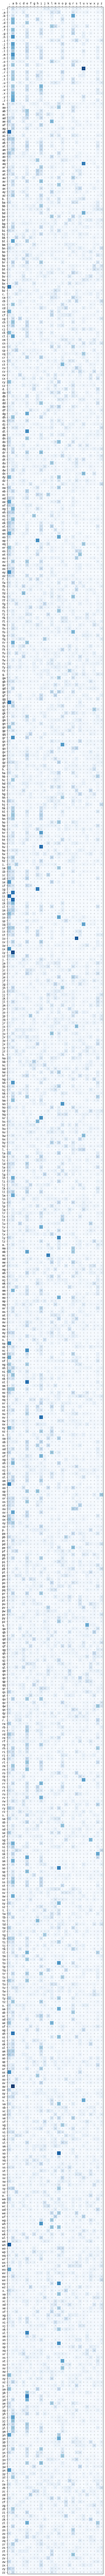

In [11]:
plt.figure(figsize=(16, 160))
plt.imshow(P.detach().numpy(), cmap="Blues")

plt.yticks(
    ticks=np.arange(27 * 27),
    labels=[itos[i] + itos[j] for i in range(27) for j in range(27)],
    fontfamily="monospace",
)
plt.xticks(
    ticks=np.arange(27),
    labels=[itos[i] for i in range(27)],
    fontfamily="monospace",
)
ax = plt.gca()
ax.xaxis.set_ticks_position("top")


for i in range(27 * 27):
    for j in range(27):
        if not P[i, j].isnan():
            text = f"{P[i, j].item() * 100:.0f}"
            plt.text(
                j,
                i,
                text,  #
                ha="center",
                va="center",
                color="gray",
                fontsize=5,
            )